# Fort Bragg Arrests Data cleanup and analysis
Source: [Fort Bragg arrests FOIA data](https://www.muckrock.com/foi/fort-bragg-3216/mendocino-county-law-enforcement-data-calls-for-service-arrests-complaints-fort-bragg-police-department-101427/)
- I converted to a messy excel file using https://pdftables.com/
- I then used `fortbragg_pd.py` to clean up most of the messy excel
- Finally, we did manual data QA in a spreadsheet to remove any other errors.

### Subset charges to most serious offense per arrest
Each booin can have multiple charges per arrest. For analysis, it is more useful to focus on only the owrst charge per arrest. The next section subsets the charge to the one with the lowest sum code according to ____ (some organization)

In [17]:
import pandas as pd

# LOAD DATA AND CODE TABLE
data = pd.read_csv('fbpd_19_cleaned.csv')
codes = pd.read_csv('le_code.csv')

# REFORMAT CODE TABLE TO MATCH DATA
codes['code_section_cleaned']=codes['Code\n Section'].str.replace(' ','')
codes['Sum_Code']=codes['Sum\n Code']
codes['Offense_Level']=codes['Off\nLevel']

# TAKE ONY THE LOWEST SUM CODE FOR EACH CODE
codes_clean = codes[['code_section_cleaned', 'Offense_Level','Sum_Code']].drop_duplicates().dropna()
codes_clean = codes_clean.loc[codes_clean.groupby(['code_section_cleaned','Offense_Level'])['Sum_Code'].idxmin()]

# SOME DATA CLEANUP
data.loc[(data['Code']=='853.7'),'Felony/Misdemeanor']='M'
data.loc[(data['Code']=='23152(A)'),'Felony/Misdemeanor']='M'
data.loc[(data['Code']=='12022.1'),'Felony/Misdemeanor']='F'

# JOIN DATA AND CODES
tst = data.merge(codes_clean, left_on=['Code','Felony/Misdemeanor'], right_on=['code_section_cleaned','Offense_Level'], how='left')
# IF CODE NOT PRESENT SET TO -1
tst.loc[tst['Sum_Code'].isnull(),'Sum_Code'] = -1

def sum_code_fix(x):
    if x['Felony/Misdemeanor']=='I':
        return 99
    if x['Felony/Misdemeanor']=='F':
        if x['Code']=='273.5':
            return 6
        if x['Code']=='666':
            return 9
        if x['Code'] in ['1203.2','1203.2(A)','12022.1']:
            return 28
    if x['Felony/Misdemeanor']=='M':
        if x['Code']=='1203.2(A)':
            return 67
        if x['Code'] in ['23578', '23540']:
            return 51
        if x['Code'] in ['20002','20002(A)']:
            return 52
        if x['Code'] in ['484','484(A)/488','666/484(A)','666/484','6646/484']:
            return 31
        if x['Code']=='11550':
            return 36
        if x['Code']=='23103':
            return 53
        if x['Code']=='6081':
            return 60
        if x['Code'].startswith('9.68.') or x['Code'].startswith('09.68.') or (x['Code']=='1170.12'):
            return 100
    return x['Sum_Code']


tst['Sum_Code_Fix'] = tst.apply(sum_code_fix, axis=1)

# TAKE ONLY THE ROW WITH THE LOWEST SUM CODE
subset_tst = tst.loc[tst.groupby('Booking#')['Sum_Code_Fix'].idxmin()]

# MAKE SURE 1 OUTPUT PER BOOKING
assert subset_tst.shape[0]==tst['Booking#'].unique().shape[0]

# SAVE TO FILE
subset_tst.to_csv('fbpd_19_subset_worst_offense.csv',index=False)
subset_tst['Arrested Date'] = pd.to_datetime(subset_tst['Arrested Date'].str[:8],format="%m/%d/%y")

In [18]:
subset_tst.head()

,Code,VC/FC,Felony/Misdemeanor,Description,Booking#,Arrested Date,Gender,Height,Weight,Hair,...,Location,Officer Name,Other1,Other2,Other3,Other4,code_section_cleaned,Offense_Level,Sum_Code,Sum_Code_Fix
0,23152(A),VC,M,DUI W/PRIORS:PER 23550 VC,FJ1900001,2019-01-02,F,409.0,130.0,BROWN,...,"250 CYPRESS ST , FORT BRAGG",MARTINEZ,NaN,NaN,NaN,NaN,23152(A),M,51.0,51.0
2,273.6(A),PC,M,VIO ORD:PREVNT DOMES VIOL,FJ1900002,2019-01-02,M,600.0,170.0,BROWN,...,"250 CYPRESS ST , FORT BRAGG",MARTINEZ,NaN,NaN,NaN,NaN,273.6(A),M,60.0,60.0
3,20002(A),VC,M,HIT AND RUN:PROP DAMAGE,FJ1900003,2019-01-03,F,410.0,135.0,BLACK,...,"250 CYPRESS ST , FORT BRAGG",LEE,"$7,500",MCTM-CRNT-2018-92930-1,TEN MILE,OUTSIDE WAR,NaN,NaN,-1.0,52.0
6,242,PC,M,BATTERY ON PERSON,FJ1900004,2019-01-04,M,509.0,206.0,BROWN,...,"410 N HARRISON ST , FORT BRAGG",RAFANAN,NaN,NaN,NaN,NaN,242,M,30.0,30.0
7,4463(A)(1),VC,M,FORGE/ALTER VEH REG/ETC,FJ1900005,2019-01-05,M,505.0,165.0,RED,...,"100 WEST CYPRESS ST , FORT BRAGG",AWAD,NaN,NaN,NaN,NaN,4463(A)(1),M,32.0,32.0


Text(0, 0.5, 'Total Arrests')

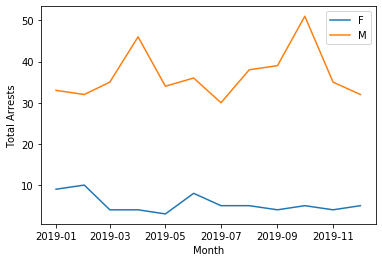

In [20]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

toplot = subset_tst.loc[subset_tst['Felony/Misdemeanor'].isin(['F','M'])].groupby(['Felony/Misdemeanor',pd.Grouper(key='Arrested Date',freq='MS')]).size().reset_index()
for r in toplot['Felony/Misdemeanor'].unique():
    subtoplot = toplot.loc[toplot['Felony/Misdemeanor']==r]
    plt.plot(subtoplot['Arrested Date'],subtoplot[0],label=r)
plt.legend()
plt.xlabel('Month')
plt.ylabel('Total Arrests')

Text(0, 0.5, 'Percentage By Race')

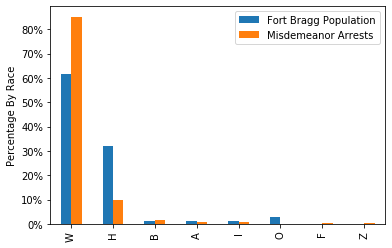

In [4]:
misdem = subset_tst.loc[subset_tst['Felony/Misdemeanor']=='M']
fb_demo = pd.Series([4489/7298, 2350/7298, 74/7298, 86/7298, 85/7298, 214/7298],index=['W', 'H', 'B', 'A', 'I', 'O'])
toplot = pd.concat([fb_demo,(misdem['Race'].value_counts()/misdem.shape[0])],axis=1)
toplot.columns = ['Fort Bragg Population', 'Misdemeanor Arrests']
ax = toplot.plot.bar()
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.ylabel('Percentage By Race')

Text(0, 0.5, 'count')

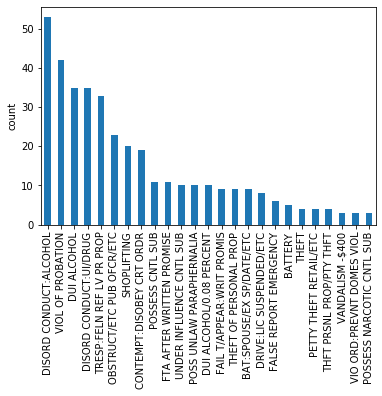

In [5]:
subset_tst.loc[subset_tst['Felony/Misdemeanor']=='M','Description'].value_counts().head(25).plot.bar()
plt.ylabel('count')

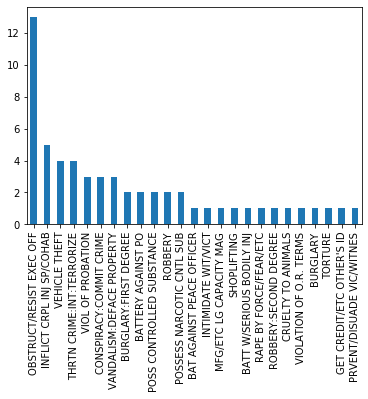

In [6]:
subset_tst.loc[subset_tst['Felony/Misdemeanor']=='F','Description'].value_counts().head(25).plot.bar()